In [1]:
using ProgressBars
using ITensors,ITensorMPS
using PastaQ
using RandomMeas

In [9]:
#Perform RM in the first experiment
N = 6
ξ = siteinds("Qubit", N)

p,dp = 0.15,0.02
p_vec = [max(0, min(p + dp * randn(), 1)) for i in 1:N]
G = 1 .-p_vec/2

circuit = randomcircuit(N, depth=2)
states = ["Dn" for n in 1:N]
ψ0  = MPS(ComplexF64,ξ,states)

ρ0 = outer(ψ0',ψ0)
ρ0n = copy(ρ0)
Apply_depo_channel!(ρ0n,ξ,p_vec)

#
ρ = runcircuit(ρ0,circuit)
ρn = copy(ρ)
Apply_depo_channel!(ρn,ξ,p_vec)
#ρ = runcircuit(circuit;noise = noisemodel);
println("state prepared in the `experiment' 1 ")
#RM on a calibration state


nu=100 #Number of random unitaries
NM=10000 #Number of projective measurements per unitary

state prepared in the `experiment' 1 


10000

In [10]:
#Calibration experiment
Gs = zeros(Float64,N)
for r in ProgressBar(1:nu, printing_delay=2)
        u = get_rotations(ξ,1) #Haar rotations in A
        data = get_RandomMeas(ρ0n,u,NM)
        σu = apply(u,ρ0,apply_dag=true)
        #σu = rotate(ρ0,u)
        for i in 1:N
            P = get_Born(data[:,i:i],ξ[i:i])
            #P2 = get_Born_data_binary(datat2[:,i:i],ξ[i:i])
            #@show norm(P-P2)
            σui,ξi = reduce_dm(σu,collect(i:i))
            Pσ = get_Born(σui)
            Gs[i] += real((3*(P-Pσ)*Pσ)[]+1)/nu
            #Gs[i] += real((3*(P-Pσ)*Pσ)[]+1)/nu
        end
end
println(G)
println(Gs)

0.0%┣                                              ┫ 0/100 [00:00<00:00, -0s/it]


[0.9250468137456483, 0.9283459222204521, 0.9275811976108999, 0.9191899673938342, 0.9311327267115661, 0.9290524334234013]
[0.9238860509387582, 0.9383451290950853, 0.9254439492840573, 0.9288241997232368, 0.932018601791854, 0.9291481288211862]


100.0%┣██████████████████████████████████████████┫ 100/100 [00:02<00:00, 54it/s]
100.0%┣██████████████████████████████████████████┫ 100/100 [00:02<00:00, 54it/s]


In [11]:
u = Vector{Vector{ITensor}}()
data = zeros(Int8,nu,NM,N)
for r in ProgressBar(1:nu, printing_delay=2)
            push!(u,get_rotations(ξ,1)) #generate random unitary
            data[r,:,:] = get_RandomMeas(ρn,u[r],NM) #data acquisation in simulated quantum device
end

0.0%┣                                              ┫ 0/100 [00:00<00:00, -0s/it]
100.0%┣█████████████████████████████████████████┫ 100/100 [00:01<00:00, 139it/s]
100.0%┣█████████████████████████████████████████┫ 100/100 [00:01<00:00, 139it/s]


In [12]:
ITensors.disable_warn_order()
purity = zeros(Float64,N)
purity_nonmit = zeros(Float64,N)
purity_mit = zeros(Float64,N)

for NA in ProgressBar(1:N, printing_delay=2)
        purity[NA] = get_purity(ρ,collect(1:NA),ξ)
        uA = [ut[1:NA] for ut in u]
        purity_nonmit[NA] = get_purity_shadows(data[:,:,1:NA],uA,ξ[1:NA])
        purity_mit[NA] = get_purity_shadows(data[:,:,1:NA],uA,ξ[1:NA];G=Gs)

end

0.0%┣                                                ┫ 0/6 [00:00<00:00, -0s/it]
100.0%┣███████████████████████████████████████████████┫ 6/6 [00:01<00:00, 4it/s]
100.0%┣███████████████████████████████████████████████┫ 6/6 [00:01<00:00, 4it/s]


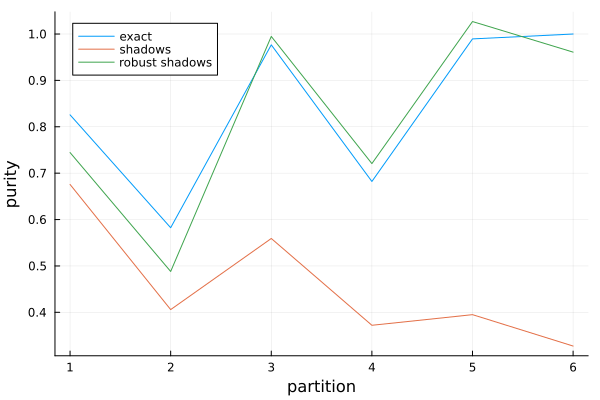

In [13]:
using Plots
plot(1:N,purity,label="exact")
plot!(1:N,purity_nonmit,label="shadows")
plot!(1:N,purity_mit,label="robust shadows")
xlabel!("partition")
ylabel!("purity")